In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


### Set-up

In [2]:
import pandas as pd
import numpy as np

# load

df = pd.read_pickle("saved/inst.dat")

# drop redundant cols

from functions.labels import *

label_dicts = {
    "tgt": tgt_labels,
    "fiw": fiw_labels,
    "ief": ief_labels,
    "efw": efw_labels,
    "pts": pts_labels,
    "p5d": p5d_labels,
    "wb_iq": wb_iq_labels,
    "wgi": wgi_labels,
    "controls": controls_labels,
}

keep_cols = ['country', 'year', 'iso_code_1','iso_code_2', 'region'] + [v for d in label_dicts.values() for v in d.keys()]
dropped = [c for c in df.columns if c not in keep_cols]
df = df[[c for c in df.columns if c in keep_cols]].copy()
print(f"Kept {len(df.columns)} cols, dropped {len(dropped)}")

Kept 136 cols, dropped 83


In [3]:
# create lagged target var, drop other target vars

from functions.utils import prep_target

df = prep_target(df)

# drop countries without target data

b_obs, b_cty = len(df), df["country"].nunique()
valid_countries = df.groupby('country')['tgt_spread'].transform(lambda x: x.notna().any())
df = df[valid_countries].copy().reset_index(drop=True)
a_obs, a_cty = len(df), df["country"].nunique()

print(f"Kept {a_cty} countries, dropped {b_cty - a_cty}\nKept {a_obs:,} obs, dropped {(b_obs - a_obs):,}")

Kept 71 countries, dropped 127
Kept 4,605 obs, dropped 7,933


Median year for 75% coverage: 2016


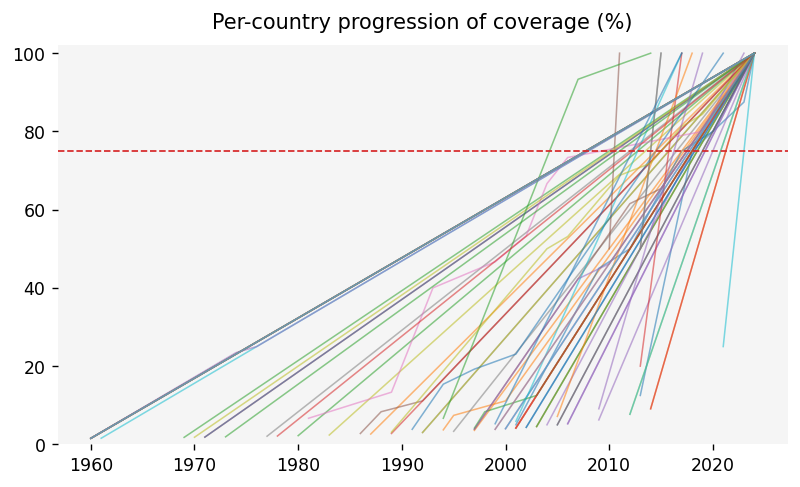

In [4]:
# identify split year as year when countries have c. 75% behind them

yname = "tgt_spread"

dff = df.dropna(subset=[yname]).sort_values(["country", "year"])
dff["cum_share"] = (dff.groupby("country").cumcount() + 1) / dff.groupby("country")["year"].transform("count")
cross_years = dff.loc[dff["cum_share"] >= 0.75].groupby("country")["year"].min()
print(f"Median year for 75% coverage: {int(cross_years.median())}")

from functions.plot import coverage_progression

coverage_progression(df)

In [5]:
# forward-fill

from functions.fill import fill

df_ff = fill(df)

# remove stale observations (fills from 3+ years)

fcols = [c for c in df_ff.columns if c.endswith("_f") and c != "fiw_f"]
ffilled_count = 0
removed_count = 0

for fcol in fcols:
    base = fcol[:-2]
    if base in df_ff.columns:
        m_ffilled = (df_ff[fcol] > 0) & (df_ff[fcol] <= 3) & df_ff[base].notna()
        m_removed = (df_ff[fcol] > 3) & df_ff[base].notna()
        ffilled_count += m_ffilled.sum()
        removed_count += m_removed.sum()
        df_ff.loc[df_ff[fcol] > 3, base] = np.nan

# fills summary

print(f"\n{removed_count:,} f-filled values removed due to staleness (3+ years), {ffilled_count:,} f-filled values remain")

from functions.fill import save_nulls_share

df_ff = save_nulls_share(df_ff, 'ffill')
print(f"Average observation null share decreased from {df_ff["nulls_init"].mean()*100:.0f} to {df_ff["nulls_ffill"].mean()*100:.0f} percent")
df_ff = df_ff.drop(columns=["nulls_init", "nulls_ffill"])

# drop _f metadata cols for further processing

fcols = [c for c in df_ff.columns if c.endswith("_f") and c != "fiw_f"]
df = df_ff.drop(columns=fcols)

F-filling Angola values
F-filling Armenia values
F-filling Australia values
F-filling Austria values
F-filling Bangladesh values
F-filling Belgium values
F-filling Botswana values
F-filling Brazil values
F-filling Bulgaria values
F-filling Canada values
F-filling Chile values
F-filling China values
F-filling Colombia values
F-filling Costa Rica values
F-filling Croatia values
F-filling Cyprus values
F-filling Czechia values
F-filling Côte d'Ivoire values
F-filling Denmark values
F-filling Estonia values
F-filling Fiji values
F-filling Finland values
F-filling France values
F-filling Germany values
F-filling Ghana values
F-filling Greece values
F-filling Hungary values
F-filling Iceland values
F-filling India values
F-filling Indonesia values
F-filling Ireland values
F-filling Israel values
F-filling Italy values
F-filling Japan values
F-filling Kyrgyzstan values
F-filling Latvia values
F-filling Lithuania values
F-filling Luxembourg values
F-filling Malaysia values
F-filling Malta valu

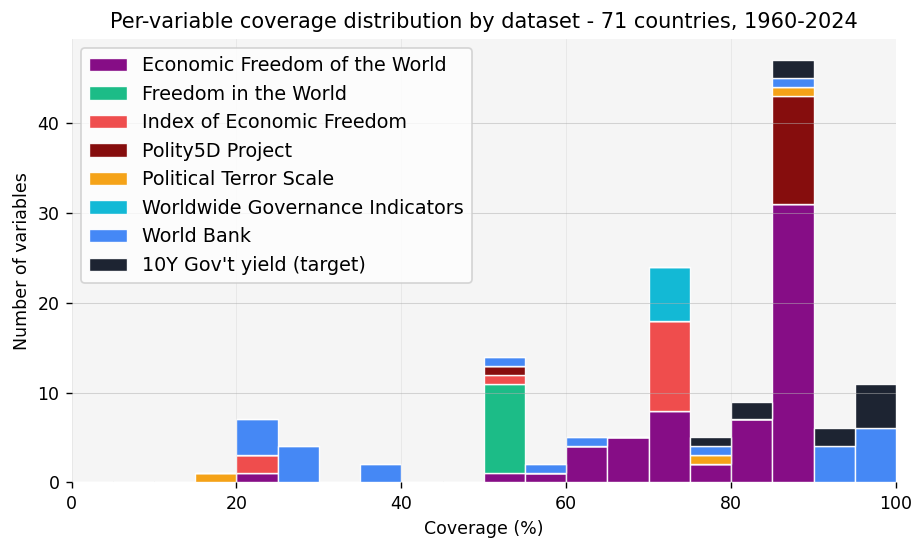

Removed 14 columns with less than 40% coverage, 289 remain
Removed ['efw_5diii_distorton_of_the_business_environment', 'ief_judicial_effectiveness', 'ief_fiscal_health', 'pts_pts_h', 'wb_iq_sci_mthd', 'wb_iq_sci_ovrl', 'wb_iq_sci_prdc', 'wb_iq_sci_srce', 'wb_iq_spi_ovrl', 'wb_iq_spi_pil2', 'wb_iq_spi_pil4', 'wb_iq_spi_pil5', 'wb_iq_wef_cust_xq', 'wb_iq_wef_port_xq']


In [6]:
# show columns coverage

from functions.plot import coverage_per_variable

likely_df = df[df.tgt_spread.notna()]
coverage_per_variable(likely_df)

# drop columns with less than 40% coverage

coverage = likely_df.notna().mean()
to_drop = coverage[coverage < 0.4].index
df = df.drop(columns=to_drop)
print(f"Removed {len(to_drop)} columns with less than 40% coverage, {df_ff.shape[1]} remain")
print("Removed", to_drop.tolist() )

In [7]:
# create engineered variables for macro and IQ

from functions.utils import engineer_lag_vars

id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region", "tgt_spread", "tgt_spread_lag"]
macro_vars = [c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_")]
iq_vars = [c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in id_cols))]

df = engineer_lag_vars(df, macro_vars, iq_vars)

# save dataset

df.to_pickle("saved/df.dat")

Added 762 engineered columns


### Function

In [3]:
import os, time
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from IPython.display import display
from joblib import Parallel, delayed

def _yearwise_splits(years, min_train_years=8, stride=2):
    ys = np.asarray(years)
    uniq = np.sort(np.unique(ys))
    for k in range(min_train_years, len(uniq), stride):
        train = np.where(np.isin(ys, uniq[:k]))[0]
        val = np.where(ys == uniq[k])[0]
        yield train, val

def _rmse_for_param(param, X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2):
    rmse = []
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=10000, warm_start=True)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=10000)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    for tr, va in _yearwise_splits(years, min_train_years, stride):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[va])
        rmse.append(np.sqrt(mean_squared_error(y.iloc[va], pred)))
    return param, float(np.mean(rmse)) if rmse else np.inf

def choose_param_expanding(X, y, years, model_type='lasso', l1_ratio=0.5, params_coarse=None, params_fine=12, min_train_years=8, stride=2, n_jobs=-1):
    if params_coarse is None:
        params_coarse = np.logspace(0, 5, 20) if model_type == 'ridge' else np.logspace(-4, 1, 15)
    coarse = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(params_coarse, reverse=True)
    )
    p0 = min(coarse, key=lambda t: t[1])[0]
    low, high = p0/10, p0*10
    fine_grid = np.logspace(np.log10(low), np.log10(high), params_fine)
    fine = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(fine_grid, reverse=True)
    )
    return min(fine, key=lambda t: t[1])[0]

def _dm_test(e0, e1):
    d = e0**2 - e1**2
    T = len(d)
    v = np.var(d, ddof=1)
    if T < 2 or v == 0 or np.isnan(v):
        return np.nan, np.nan
    stat = d.mean() / np.sqrt(v / T)
    pval = 2 * (1 - norm.cdf(abs(stat)))
    return stat, pval

def decompose_r2(y_true, y_pred, X, coefs, feature_names):
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    X = np.asarray(X)
    coefs = np.asarray(coefs).flatten()
    y_centered = y_true - y_true.mean()
    X_centered = X - X.mean(axis=0)
    contributions = []
    for j in range(X.shape[1]):
        cov_j = np.dot(X_centered[:, j], y_centered) / len(y_centered)
        contrib = coefs[j] * cov_j
        contributions.append(contrib)
    contributions = np.array(contributions)
    total_contrib = contributions.sum()
    r2 = r2_score(y_true, y_pred)
    if total_contrib != 0:
        normalized_contrib = (contributions / total_contrib) * r2
    else:
        normalized_contrib = np.zeros_like(contributions)
    decomp_df = pd.DataFrame({
        'variable': feature_names,
        'coefficient': coefs,
        'contribution': contributions,
        'r2_contribution': normalized_contrib,
        'r2_contribution_pct': normalized_contrib * 100
    })
    decomp_df = decomp_df.reindex(decomp_df['r2_contribution'].abs().sort_values(ascending=False).index)
    return decomp_df

def run_unified_regularized_regression(
    name_prefix="base",
    data_path="saved/df.dat",
    macro_cols=None,
    iq_cols=None,
    y_name="tgt_spread",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['lasso', 'ridge', 'elastic'],
    agnostic=True,
    param_factors=[0.5, 1.0, 2.0],
    l1_ratios=[0.5],
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=None,
    rmse_benchmark=None,
    early_stop_threshold=0.10,
    save_results=True,
    output_dir="specs",
    n_jobs=-1
):
    print(f"\n{'='*80}")
    print(f"UNIFIED REGULARIZED REGRESSION: {name_prefix.upper()}")
    print(f"Specification: {'Agnostic (β unrestricted)' if agnostic else 'β=1 (mean reversion)'}")
    print(f"Models: {', '.join([m.upper() for m in model_types])}")
    if 'elastic' in model_types:
        print(f"Elastic Net L1 ratios: {l1_ratios}")
    print(f"{'='*80}\n")
    start_time = time.time()
    df = pd.read_pickle(data_path)
    df = df[df[y_name].notna()]
    df[year_col] = df[year_col].astype(int)
    if macro_cols is None:
        macro_cols = []
    if iq_cols is None:
        iq_cols = []
    train_data = df[df[year_col] <= split_year].copy()
    test_data = df[df[year_col] > split_year].copy()
    print(f"Train: {train_data[year_col].min()}-{train_data[year_col].max()} ({len(train_data)} obs)")
    print(f"Test:  {test_data[year_col].min()}-{test_data[year_col].max()} ({len(test_data)} obs)\n")
    feature_cols = macro_cols + iq_cols
    if spread_col in feature_cols and not agnostic:
        feature_cols = [c for c in feature_cols if c != spread_col]
    X_train_raw = train_data[feature_cols].copy()
    X_test_raw = test_data[feature_cols].copy()
    y_train = train_data[y_name].copy()
    y_test = test_data[y_name].copy()
    years_train = train_data[year_col].values
    if not agnostic:
        if spread_col not in train_data.columns:
            raise ValueError(f"β=1 specification requires '{spread_col}' column")
        spread_train = train_data[spread_col].copy()
        spread_test = test_data[spread_col].copy()
        mask_train = spread_train.notna() & y_train.notna()
        mask_test = spread_test.notna() & y_test.notna()
        X_train_raw = X_train_raw.loc[mask_train]
        X_test_raw = X_test_raw.loc[mask_test]
        y_train = y_train.loc[mask_train]
        y_test = y_test.loc[mask_test]
        spread_train = spread_train.loc[mask_train]
        spread_test = spread_test.loc[mask_test]
        years_train = years_train[mask_train.values]
        y_train_adj = y_train - spread_train
        y_test_adj = y_test - spread_test
        print(f"β=1 specification: predicting (y_t+1 - spread_t)")
        print(f"After removing NaN: {len(y_train_adj)} train, {len(y_test_adj)} test obs\n")
    else:
        y_train_adj = y_train
        y_test_adj = y_test
        spread_train = None
        spread_test = None
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train_raw)
    X_test_imp = imputer.transform(X_test_raw)
    X_train = pd.DataFrame(scaler.fit_transform(X_train_imp), index=X_train_raw.index, columns=X_train_raw.columns)
    X_test = pd.DataFrame(scaler.transform(X_test_imp), index=X_test_raw.index, columns=X_test_raw.columns)
    feature_names = list(X_train.columns)
    print(f"Features: {len(feature_names)}\n")
    all_results = {}

    for model_type in model_types:
        if model_type == 'elastic':
            for l1_ratio in l1_ratios:
                model_name = f"{model_type}_l1_{l1_ratio}"
                print(f"\n{'-'*80}")
                print(f"RUNNING {model_type.upper()} (L1 ratio={l1_ratio})")
                print(f"{'-'*80}\n")
                if use_expanding_cv:
                    print("Selecting optimal parameter via expanding window CV...")
                    optimal_param = choose_param_expanding(X_train, y_train_adj, years_train, model_type=model_type, l1_ratio=l1_ratio, min_train_years=min_train_years, stride=cv_stride, n_jobs=n_jobs)
                else:
                    params = np.logspace(-4, 1, 30)
                    best_score = -np.inf
                    optimal_param = params[0]
                    for p in params:
                        m = ElasticNet(alpha=p, l1_ratio=l1_ratio, max_iter=10000)
                        m.fit(X_train, y_train_adj)
                        score = m.score(X_train, y_train_adj)
                        if score > best_score:
                            best_score = score
                            optimal_param = p
                print(f"Optimal parameter: {optimal_param:.6f}\n")
                results_rows = []
                models = {}
                best_r2_test = -np.inf
                for factor in param_factors:
                    param = optimal_param * factor
                    model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=10000)
                    model.fit(X_train, y_train_adj)
                    y_pred_test_adj = model.predict(X_test)
                    y_pred_train_adj = model.predict(X_train)
                    if not agnostic:
                        y_pred_test = spread_test + y_pred_test_adj
                        y_pred_train = spread_train + y_pred_train_adj
                    else:
                        y_pred_test = y_pred_test_adj
                        y_pred_train = y_pred_train_adj
                    r2_train = r2_score(y_train, y_pred_train)
                    r2_test = r2_score(y_test, y_pred_test)
                    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
                    active_vars = np.sum(model.coef_ != 0)
                    if not agnostic:
                        e_benchmark = y_test - spread_test
                        e_model = y_test - y_pred_test
                        dm_stat, dm_p = _dm_test(e_benchmark, e_model)
                    else:
                        dm_stat, dm_p = np.nan, np.nan
                    results_rows.append({'factor': factor, 'param': param, 'l1_ratio': l1_ratio, 'R²_train': r2_train, 'R²_test': r2_test, 'RMSE_test': rmse_test, 'Active_vars': active_vars, 'DM_stat': dm_stat, 'DM_p': dm_p})
                    models[factor] = (model, y_pred_test)
                    if r2_test > best_r2_test:
                        best_r2_test = r2_test
                    elif best_r2_test - r2_test > early_stop_threshold:
                        print(f"Early stopping: R² dropped by {(best_r2_test - r2_test)*100:.2f} p.p. (threshold: {early_stop_threshold*100:.1f} p.p.)")
                        break
                results_df = pd.DataFrame(results_rows)
                display(results_df)
                best_idx = results_df['R²_test'].idxmax()
                best_row = results_df.iloc[best_idx]
                best_model, best_pred = models[best_row['factor']]
                print(f"\nBest {model_type.upper()} (L1={l1_ratio}):")
                print(f"  Parameter: {best_row['param']:.6f}")
                print(f"  R² (test): {best_row['R²_test']:.4f}")
                print(f"  RMSE (test): {best_row['RMSE_test']:.4f}")
                print(f"  Active vars: {int(best_row['Active_vars'])}")
                if r2_benchmark is not None:
                    print(f"  ΔR² vs benchmark: {(best_row['R²_test'] - r2_benchmark)*100:+.2f} p.p.")
                if rmse_benchmark is not None:
                    print(f"  ΔRMSE vs benchmark: {(best_row['RMSE_test'] - rmse_benchmark):+.4f}")
                if not agnostic:
                    print(f"  DM test: stat={best_row['DM_stat']:.2f}, p={best_row['DM_p']:.3f}")
                print(f"\n{'='*80}")
                print(f"VARIABLE IMPORTANCE DECOMPOSITION ({model_type.upper()}, L1={l1_ratio})")
                print(f"{'='*80}\n")
                decomp_df = decompose_r2(y_test, best_pred, X_test, best_model.coef_, feature_names)
                top_n = min(20, len(decomp_df))
                print(f"Top {top_n} contributors to R²:\n")
                display(decomp_df.head(top_n)[['variable', 'coefficient', 'r2_contribution', 'r2_contribution_pct']])
                total_r2_explained = decomp_df['r2_contribution'].sum()
                print(f"\nTotal R² explained: {total_r2_explained:.4f}")
                print(f"Sum of absolute contributions: {decomp_df['r2_contribution'].abs().sum():.4f}")
                if save_results:
                    os.makedirs(output_dir, exist_ok=True)
                    suffix = f"{'_agn' if agnostic else ''}_l1_{l1_ratio}"
                    results_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_results.dat")
                    decomp_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_decomp.dat")
                    pd.Series(best_model.coef_, index=feature_names).to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_coefs.dat")
                all_results[model_name] = {'results_df': results_df, 'best_model': best_model, 'best_row': best_row, 'decomposition': decomp_df, 'predictions': best_pred, 'l1_ratio': l1_ratio}
        else:
            print(f"\n{'-'*80}")
            print(f"RUNNING {model_type.upper()}")
            print(f"{'-'*80}\n")
            if use_expanding_cv:
                print("Selecting optimal parameter via expanding window CV...")
                optimal_param = choose_param_expanding(X_train, y_train_adj, years_train, model_type=model_type, l1_ratio=0.5, min_train_years=min_train_years, stride=cv_stride, n_jobs=n_jobs)
            else:
                params = np.logspace(0, 5, 30) if model_type == 'ridge' else np.logspace(-4, 1, 30)
                best_score = -np.inf
                optimal_param = params[0]
                for p in params:
                    if model_type == 'lasso':
                        m = Lasso(alpha=p, max_iter=10000)
                    elif model_type == 'ridge':
                        m = Ridge(alpha=p)
                    m.fit(X_train, y_train_adj)
                    score = m.score(X_train, y_train_adj)
                    if score > best_score:
                        best_score = score
                        optimal_param = p
            print(f"Optimal parameter: {optimal_param:.6f}\n")
            results_rows = []
            models = {}
            best_r2_test = -np.inf
            for factor in param_factors:
                param = optimal_param * factor
                if model_type == 'lasso':
                    model = Lasso(alpha=param, max_iter=10000)
                elif model_type == 'ridge':
                    model = Ridge(alpha=param)
                model.fit(X_train, y_train_adj)
                y_pred_test_adj = model.predict(X_test)
                y_pred_train_adj = model.predict(X_train)
                if not agnostic:
                    y_pred_test = spread_test + y_pred_test_adj
                    y_pred_train = spread_train + y_pred_train_adj
                else:
                    y_pred_test = y_pred_test_adj
                    y_pred_train = y_pred_train_adj
                r2_train = r2_score(y_train, y_pred_train)
                r2_test = r2_score(y_test, y_pred_test)
                rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
                active_vars = np.sum(model.coef_ != 0)
                if not agnostic:
                    e_benchmark = y_test - spread_test
                    e_model = y_test - y_pred_test
                    dm_stat, dm_p = _dm_test(e_benchmark, e_model)
                else:
                    dm_stat, dm_p = np.nan, np.nan
                results_rows.append({'factor': factor, 'param': param, 'R²_train': r2_train, 'R²_test': r2_test, 'RMSE_test': rmse_test, 'Active_vars': active_vars, 'DM_stat': dm_stat, 'DM_p': dm_p})
                models[factor] = (model, y_pred_test)
                if r2_test > best_r2_test:
                    best_r2_test = r2_test
                elif best_r2_test - r2_test > early_stop_threshold:
                    print(f"Early stopping: R² dropped by {(best_r2_test - r2_test)*100:.2f} p.p. (threshold: {early_stop_threshold*100:.1f} p.p.)")
                    break
            results_df = pd.DataFrame(results_rows)
            display(results_df)
            best_idx = results_df['R²_test'].idxmax()
            best_row = results_df.iloc[best_idx]
            best_model, best_pred = models[best_row['factor']]
            print(f"\nBest {model_type.upper()}:")
            print(f"  Parameter: {best_row['param']:.6f}")
            print(f"  R² (test): {best_row['R²_test']:.4f}")
            print(f"  RMSE (test): {best_row['RMSE_test']:.4f}")
            print(f"  Active vars: {int(best_row['Active_vars'])}")
            if r2_benchmark is not None:
                print(f"  ΔR² vs benchmark: {(best_row['R²_test'] - r2_benchmark)*100:+.2f} p.p.")
            if rmse_benchmark is not None:
                print(f"  ΔRMSE vs benchmark: {(best_row['RMSE_test'] - rmse_benchmark):+.4f}")
            if not agnostic:
                print(f"  DM test: stat={best_row['DM_stat']:.2f}, p={best_row['DM_p']:.3f}")
            print(f"\n{'='*80}")
            print(f"VARIABLE IMPORTANCE DECOMPOSITION ({model_type.upper()})")
            print(f"{'='*80}\n")
            decomp_df = decompose_r2(y_test, best_pred, X_test, best_model.coef_, feature_names)
            top_n = min(20, len(decomp_df))
            print(f"Top {top_n} contributors to R²:\n")
            display(decomp_df.head(top_n)[['variable', 'coefficient', 'r2_contribution', 'r2_contribution_pct']])
            total_r2_explained = decomp_df['r2_contribution'].sum()
            print(f"\nTotal R² explained: {total_r2_explained:.4f}")
            print(f"Sum of absolute contributions: {decomp_df['r2_contribution'].abs().sum():.4f}")
            if save_results:
                os.makedirs(output_dir, exist_ok=True)
                suffix = f"{'_agn' if agnostic else ''}"
                results_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_results.dat")
                decomp_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_decomp.dat")
                pd.Series(best_model.coef_, index=feature_names).to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_coefs.dat")
            all_results[model_type] = {'results_df': results_df, 'best_model': best_model, 'best_row': best_row, 'decomposition': decomp_df, 'predictions': best_pred}
    elapsed = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"COMPLETED IN {elapsed:.1f}s")
    print(f"{'='*80}\n")
    return all_results

### Mean reversion benchmark

In [ ]:
# mean-reversion as benchmark

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

fullte = pd.read_pickle("saved/macro_iq_test.dat")[["country", "year", "tgt_spread", "tgt_spread_lag"]].dropna()
y_true = fullte["tgt_spread_lag"]
y_pred = fullte["tgt_spread"]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

# show fit and prediction error

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
axes[0].scatter(y_true, y_pred, alpha=0.4, s=20)
axes[0].plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             color="red", linestyle="-", lw=1)
axes[0].set_xlabel("Actual spread (t+1)")
axes[0].set_ylabel("Predicted spread (t)")
axes[0].set_title(f"Mean-reversion benchmark\nRMSE={rmse:.2f}, R²={r2:.3f}")

errors = y_true - y_pred
axes[1].hist(errors, bins=40, color="steelblue", alpha=0.7)
axes[1].axvline(0, color="red", lw=1)
axes[1].set_title("Forecast errors")
axes[1].set_xlabel("Error (actual − predicted)")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

On average, the mean-reversion benchmark misses by about 1.3 percentage points (or 130 bps).

About 89% of the variation in next-year spreads is explained simply by the current spread — in other words, spreads are highly persistent.

In [ ]:
# how much of total variance is explained by between-country variance

df = fullte[["country", "tgt_spread_lag"]].dropna()
overall_mean = df["tgt_spread_lag"].mean()
n_i = df.groupby("country")["tgt_spread_lag"].count()
means_i = df.groupby("country")["tgt_spread_lag"].mean()

# weighted between-country variance

sst_between = ((n_i * (means_i - overall_mean)**2).sum()) / (len(df) - 1)
sst_total = ((df["tgt_spread_lag"] - overall_mean)**2).sum() / (len(df) - 1)
print(f"Share of between-country variance in total variance: {sst_between / sst_total:.2%}")

About 92% of the variation in sovereign spreads reflects persistent cross-country differences, not year-to-year changes.

This means spreads mainly differ because of structural and institutional factors, while short-term movements are small and harder to predict.

Since current pricing already embeds much of this institutional information, IQ variables may be crowded out by the spread level itself in the regularised models.

### Incremental signal

In [ ]:
# Define your columns
df = pd.read_pickle("saved/df.dat")
id_cols = ["country","year","iso_code_1","iso_code_2","region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = [c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude]
iq_cols = [c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))]

# Add today's spread level as explanatory variable
macro_cols += ["tgt_spread"]

# Run specification
results = run_unified_regularized_regression(
    name_prefix="signal",
    data_path="saved/df.dat",
    macro_cols=macro_cols,
    iq_cols=iq_cols,
    y_name="tgt_spread_lag",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['ridge', 'lasso', 'elastic'],
    agnostic=False,
    param_factors=np.logspace(-3, 10, 25),
    l1_ratios=[0.25, 0.5, 0.75],
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=0.887,
    rmse_benchmark=1.36,
    early_stop_threshold=0.10,
    save_results=True,
    output_dir="specs",
    n_jobs=-1
)

### Levels

In [ ]:
# Define your columns
df = pd.read_pickle("saved/df.dat")
id_cols = ["country","year","iso_code_1","iso_code_2","region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = [c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude]
iq_cols = [c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))]

# Run specification
results = run_unified_regularized_regression(
    name_prefix="levels",
    data_path="saved/df.dat",
    macro_cols=macro_cols,
    iq_cols=iq_cols,
    y_name="tgt_spread",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2016,
    model_types=[
        #'ridge',
        'lasso', 'elastic'],
    agnostic=True,
    param_factors=np.logspace(-3, 10, 25),
    l1_ratios=[0.25, 0.5, 0.75],
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=None,
    rmse_benchmark=None,
    early_stop_threshold=0.10,
    save_results=True,
    output_dir="specs",
    n_jobs=-1
)


UNIFIED REGULARIZED REGRESSION: LEVELS
Specification: Agnostic (β unrestricted)
Models: LASSO, ELASTIC
Elastic Net L1 ratios: [0.25, 0.5, 0.75]

Train: 1960-2016 (1765 obs)
Test:  2017-2024 (509 obs)

Features: 812


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...


### Agnostic next-year without spreads (VERSUS)

In [ ]:
# Define your columns
df = pd.read_pickle("saved/df.dat")
id_cols = ["country","year","iso_code_1","iso_code_2","region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = [c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude]
iq_cols = [c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))]

# Run specification
results = run_unified_regularized_regression(
    name_prefix="versus",
    data_path="saved/df.dat",
    macro_cols=macro_cols,
    iq_cols=iq_cols,
    y_name="tgt_spread_lag",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['ridge', 'lasso', 'elastic'],
    agnostic=True,
    param_factors=np.logspace(-3, 10, 25),
    l1_ratios=[0.25, 0.5, 0.75],
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=0.887,
    rmse_benchmark=1.36,
    early_stop_threshold=0.10,
    save_results=True,
    output_dir="specs",
    n_jobs=-1
)

### Agnostic next-year with spreads (NOISE)

In [ ]:
# Define your columns
df = pd.read_pickle("saved/df.dat")
id_cols = ["country","year","iso_code_1","iso_code_2","region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = [c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude]
iq_cols = [c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))]

# Add today's spread level as explanatory variable
macro_cols += ["tgt_spread"]

# Run specification
results = run_unified_regularized_regression(
    name_prefix="noise",
    data_path="saved/df.dat",
    macro_cols=macro_cols,
    iq_cols=iq_cols,
    y_name="tgt_spread_lag",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['ridge', 'lasso', 'elastic'],
    agnostic=True,
    param_factors=np.logspace(-3, 10, 25),
    l1_ratios=[0.25, 0.5, 0.75],
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=0.887,
    rmse_benchmark=1.36,
    early_stop_threshold=0.10,
    save_results=True,
    output_dir="specs",
    n_jobs=-1
)

### Levels lagged

In [ ]:
# Define your columns
df = pd.read_pickle("saved/df.dat")
id_cols = ["country","year","iso_code_1","iso_code_2","region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = [c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude]
iq_cols = [c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))]

# Run
targets = [f"tgt_spread_t{i}" for i in range(2, 11)]
for y in targets:
    print(f"\n=== Running model for {y} ===")
    results = run_unified_regularized_regression(
        name_prefix=f"levels_{y}",
        data_path="saved/df.dat",
        macro_cols=macro_cols,
        iq_cols=iq_cols,
        y_name=y,
        spread_col="tgt_spread",
        year_col="year",
        split_year=2016,
        model_types=['ridge', 'lasso', 'elastic'],
        agnostic=True,
        param_factors=np.logspace(-3, 10, 25),
        l1_ratios=[0.25, 0.5, 0.75],
        use_expanding_cv=True,
        min_train_years=8,
        cv_stride=2,
        r2_benchmark=None,
        rmse_benchmark=None,
        early_stop_threshold=0.10,
        save_results=True,
        output_dir="specs",
        n_jobs=-1
    )